# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = './traffic-signs-data/train.p'
testing_file = './traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [3]:
import csv
with open('./signnames.csv', 'r') as f:
    reader = csv.reader(f)
    sign_name_dict = {row[0]:row[1] for row in reader}
    try:
        del sign_name_dict['ClassId']
    except KeyError:
        pass

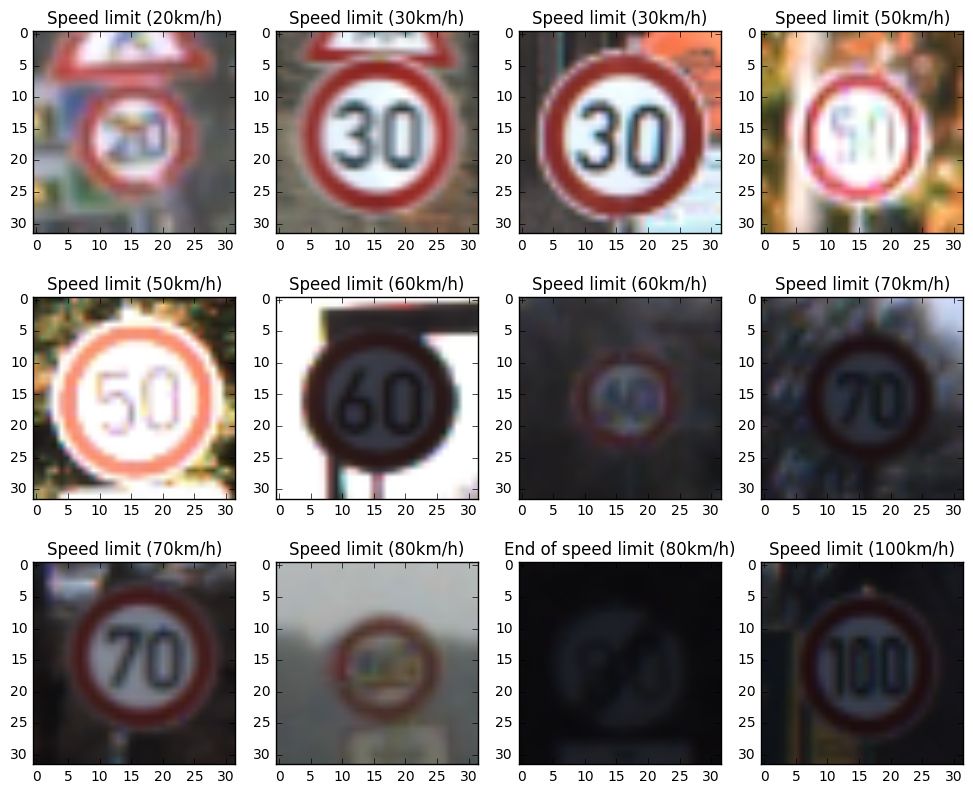

In [4]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(12,20))
i = 1

for img in range(0,12*1000,1000):
    plt.subplot(6,4,i)
    plt.title(sign_name_dict[str(y_train[img])])
    plt.imshow(X_train[img])
    i+=1

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Preprocessing the images

In [5]:
import cv2
import numpy as np

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [6]:
X_test_grayscale = np.ndarray(shape=(n_test, image_shape[0], image_shape[1]),
                         dtype=np.float32)

X_train_grayscale = np.ndarray(shape=(n_train, image_shape[0], image_shape[1]),
                         dtype=np.float32)

for i in range(n_test):
    X_test_grayscale[i] = grayscale(X_test[i])
    
for i in range(n_train):
    X_train_grayscale[i] = grayscale(X_train[i])

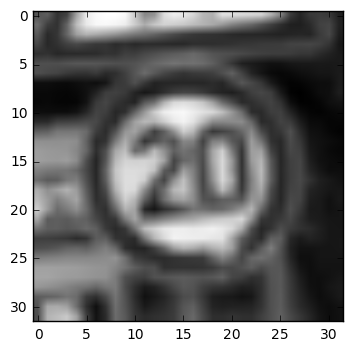

In [7]:
plt.imshow(X_train_grayscale[10],cmap='gray');

In [8]:
# normalise the images
pixel_depth = 255.0
NORMALISE_BATCH_SIZE = 5000

X_train_normalised = np.ndarray(shape=(n_train, image_shape[0], image_shape[1]),
                         dtype=np.float32)

for offset in range(0, n_train, NORMALISE_BATCH_SIZE):
    batch_end = offset+NORMALISE_BATCH_SIZE
    X_train_normalised[offset:batch_end] = (X_train_grayscale[offset:batch_end] - pixel_depth / 2) / pixel_depth

X_test_normalised = (X_test_grayscale - pixel_depth / 2) / pixel_depth

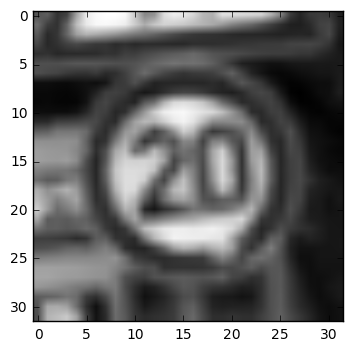

In [9]:
plt.imshow(X_train_normalised[10],cmap='gray');

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

I preprocessed the data by carrying out the following steps:

1) I converted the images to grayscale
- I did this because the RGB colors in the road signs are not significant in determining their classification. The shape of the sign and the shape of the characters in it are what is most important in classifying the sign. By converting the images to grayscale I reduced the amount of work (and hence computational time) needed to train the neural network.

2) I normalised the images be centering the pixel values to zero and downscaling the pixel values from the 0-255 range to += 0.5 , the line of code below achieves this.
```python
(X_train_grayscale[offset:batch_end] - pixel_depth / 2) / pixel_depth
```

- This helps to improve the numerical stability of the calculations by keeping all the keeping the weights and data points numerically in the same range. 

In [10]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

In [11]:
from sklearn.model_selection import train_test_split

# Get randomized datasets for training and validation
train_features, valid_features, train_labels, valid_labels = train_test_split(
    X_train_normalised,
    y_train,
    test_size=0.2,
    random_state=832289)

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

I used the **train_test_split** function from the **sklearn.model_selection** package to split my preprocessed training data and labels into a training and validation set. 

In doing this I also randomised the data. This is important because from my initial inspection of the dataset, the road signs are sorted by type of sign (starting with the 20mph speed limit sign).

20% of my original training set became my validation set

For my test set, I kept the original set that came with the German Traffic Sign Dataset after proprocessing.


In [12]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

In [13]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

In [14]:
def DalisoNet3(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.01
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x48.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 48), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(48))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)
    
    # Pooling. Input = 28x28x48. Output = 14x14x48.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # ----------------------------------------------------------------------------------
    
    # Layer 2: Convolutional. Input = 14x14x48. Output = 10x10x64.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 48, 64), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(64))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x64. Output = 5x5x64.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # ----------------------------------------------------------------------------------
    
    # Layer 3: Convolutional. Input = 5x5x64. Output = 1x1x128.
    conv3_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 64, 128), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(128))
    conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
    
    # Activation.
    conv3 = tf.nn.relu(conv3)

    # ----------------------------------------------------------------------------------    
    
    # Flatten. Input = 1x1x128. Output = 128.
    fc0   = flatten(conv3)
    
    # Layer 4: Fully Connected. Input = 128. Output = 2048.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(128, 2048), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(2048))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    
    # Layer 5: Fully Connected. Input = 2048. Output = 1024.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(2048, 1024), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(1024))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
        
    # Layer 6: Fully Connected. Input = 1024. Output = 512.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(1024, 512), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(512))
    fc3    = tf.matmul(fc2, fc3_W) + fc3_b
    
    # Activation.
    fc3    = tf.nn.relu(fc3)
    fc3 = tf.nn.dropout(fc3,keep_prob)

    # Layer 7: Fully Connected. Input = 512. Output = 43.
    fc4_W  = tf.Variable(tf.truncated_normal(shape=(512, 43), mean = mu, stddev = sigma))
    fc4_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc3, fc4_W) + fc4_b
    
    return logits

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

My final model is structured as follows:
- Three convolutional Layers
- Three fully connected layers
- A final fully connected classifier

I used ReLU for activation.

For all the convolutional layers, I used a 5x5 patch with stride 1. 

For convolutional layers 1 and 2, I used maxpool with a 2x2 kernel with stride 2. I had depths of 48, 64 and 128 respectively for each of the convolutional layers. I did not used maxpool on convolutional layer 3 since the convolution operation had at this point reduce the dimensionality to 1x1x128. 

For the three fully connected layers, I mapped to features of 2048, 1024 and 512 respectively.

On the last fully connected layer I used dropout.




In [15]:
### Train your model here.
### Feel free to use as many code cells as needed.

In [16]:
EPOCHS = 20
BATCH_SIZE = 128

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

In [17]:
rate = 0.001

logits = DalisoNet3(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [18]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

In [19]:
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x.reshape(-1,32,32,1), y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [20]:
from sklearn.utils import shuffle

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(train_features)

    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_, y_train_ = shuffle(train_features, train_labels)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = min(offset + BATCH_SIZE,num_examples-1)
            batch_x, batch_y = X_train_[offset:end], y_train_[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x.reshape(-1,32,32,1),y: batch_y, keep_prob: 0.5})

        validation_accuracy = evaluate(valid_features, valid_labels)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()

    saver.save(sess, 'traffic_sign_classifier')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.179

EPOCH 2 ...
Validation Accuracy = 0.495

EPOCH 3 ...
Validation Accuracy = 0.841

EPOCH 4 ...
Validation Accuracy = 0.910

EPOCH 5 ...
Validation Accuracy = 0.932

EPOCH 6 ...
Validation Accuracy = 0.947

EPOCH 7 ...
Validation Accuracy = 0.964

EPOCH 8 ...
Validation Accuracy = 0.967

EPOCH 9 ...
Validation Accuracy = 0.978

EPOCH 10 ...
Validation Accuracy = 0.971

EPOCH 11 ...
Validation Accuracy = 0.971

EPOCH 12 ...
Validation Accuracy = 0.974

EPOCH 13 ...
Validation Accuracy = 0.978

EPOCH 14 ...
Validation Accuracy = 0.968

EPOCH 15 ...
Validation Accuracy = 0.976

EPOCH 16 ...
Validation Accuracy = 0.978

EPOCH 17 ...
Validation Accuracy = 0.985

EPOCH 18 ...
Validation Accuracy = 0.983

EPOCH 19 ...
Validation Accuracy = 0.985

EPOCH 20 ...
Validation Accuracy = 0.980

Model saved


In [23]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test_grayscale, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.743


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

Below is the configuration I used for my model:

- For my optimizer, I used an AdamOptimizer with learning rate 0.001
- I trained with 20 EPOCHs (after some trial and error, I found that training for more than 20 EPOCHs resulted in overfitting and reduced accuracy on the Test set.
- I used a batch size of 128
- When training I used a dropout keep probability of 0.5


### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

In getting to my final solution I took the following steps:

(1) I started off with the LeNet-5 solution from the Udacity lession. I adjusted the size of the input to match the 32x32 traffic sign images, and the changed the classifier so that it used 43 classes instead of 10.

(2) When I saw that I was getting reasonable results I improved on this by applying some techniques I used before for in my Machine Learning Nanodegree capstone project.
- Added an additional convolutional layer and an additional fully connected layer 
    - _I did this to enable the network to learn more complex shapes in the image_
- Added more filters to the convolutional layers and made the fully connected layers much wider
    - _Reasoning same as above_
- Added dropout to the last fully connected layer before the classifier
     - _Since my network was more complex now, I used dropout to make sure it did not overfit. In my first version I did not have dropout and the Test accuracy was much lower_


---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [67]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import matplotlib.image as mpimg
import os

test_images = [cv2.imread('./testsign/'+img,0) for img in os.listdir("testsign/")]


In [72]:
test_images_normalised = np.ndarray(shape=(len(test_images), 32, 32),
                         dtype=np.float32)

for i in range(len(test_images)):
    test_images_normalised[i] = (test_images[i] - pixel_depth / 2) / pixel_depth

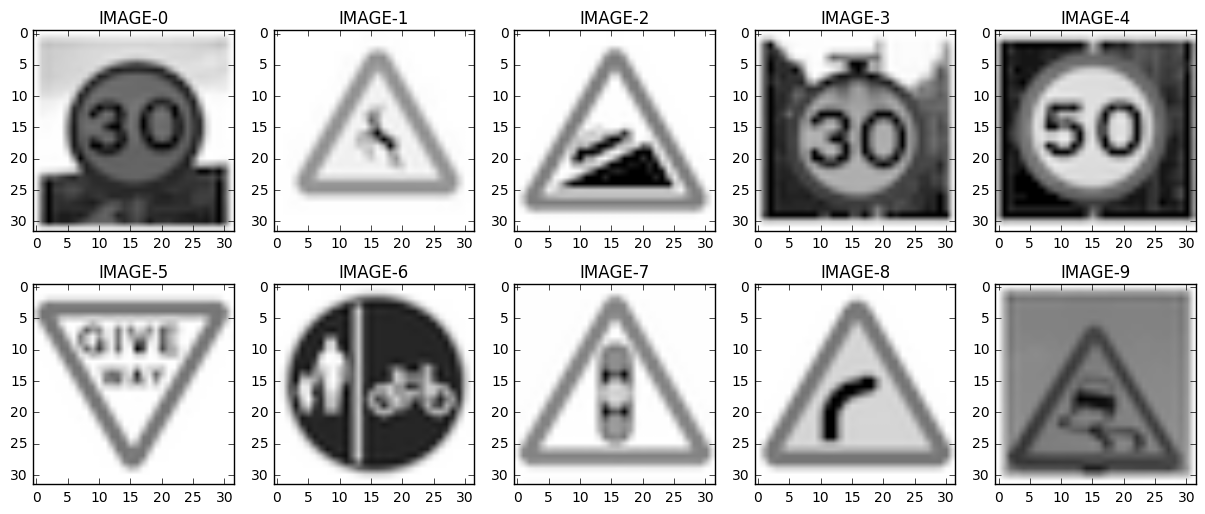

In [73]:
plt.figure(figsize=(15,6))

for img in range(10):
    plt.subplot(2,5,img+1)
    plt.title("IMAGE-"+str(img))
    plt.imshow(test_images_normalised[img],cmap='gray')

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

Images Selected:
- Image 1
- Image 2
- Image 5
- Image 6
- Image 7

These images appear to be a bit blurry which might affect the accuracy of the classification

In [79]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
prediction_operation = tf.argmax(logits, 1)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    predictions = sess.run(prediction_operation, feed_dict={x: test_images_normalised.reshape(-1,32,32,1), keep_prob: 1.0})



In [80]:
print(predictions)

[ 1 19 29  1  5 13 14 27 41 23]


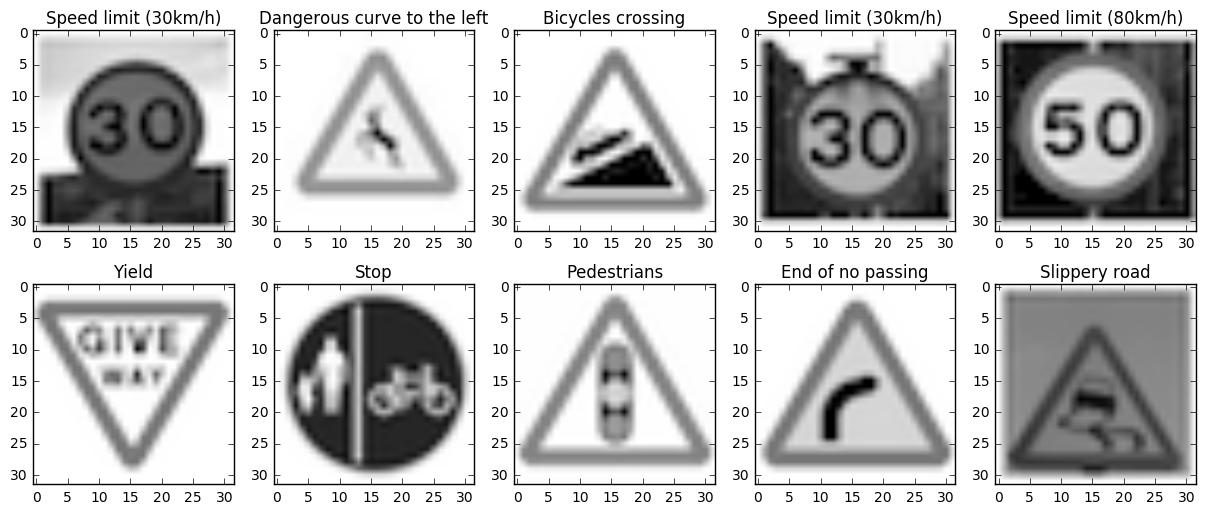

In [82]:
plt.figure(figsize=(15,6))

for img in range(10):
    plt.subplot(2,5,img+1)
    plt.title(sign_name_dict[str(predictions[img])])
    plt.imshow(test_images_normalised[img],cmap='gray')

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

Of the 10 road signs, it seems that the model correctly classified 4 (images 1,4,6,10). So the accuracy on the captured images was 40%

For image 5 is was close, it mistook the '5' for an '8' and predicted 80km/h instead of 50km/h speed limit.

This is worse than the 74.3% accuracy it got on the test dataset.

In [85]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

top_k_prediction_operation = tf.nn.top_k(tf.nn.softmax(logits), 5)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    top_k_predictions = sess.run(top_k_prediction_operation, feed_dict={x: test_images_normalised.reshape(-1,32,32,1), keep_prob: 1.0})



In [86]:
print(top_k_predictions)

TopKV2(values=array([[  5.16167104e-01,   3.91924977e-01,   4.01456691e-02,
          2.75288578e-02,   5.27562713e-03],
       [  9.04254079e-01,   4.14049663e-02,   2.84862909e-02,
          2.54196953e-02,   2.41342350e-04],
       [  9.99886632e-01,   1.10397050e-04,   2.92264963e-06,
          7.41157180e-09,   7.18681692e-09],
       [  9.99999523e-01,   4.65924927e-07,   8.32908498e-09,
          1.06581366e-09,   9.74191727e-10],
       [  8.65817130e-01,   1.03848472e-01,   2.99368072e-02,
          1.67161867e-04,   7.13551854e-05],
       [  1.00000000e+00,   3.34595907e-09,   1.34653304e-11,
          9.54254124e-12,   1.13692839e-15],
       [  9.99999881e-01,   8.17597297e-08,   2.80784924e-08,
          1.36748091e-09,   2.50768906e-10],
       [  9.99920487e-01,   7.89732803e-05,   4.77103299e-07,
          4.78916036e-08,   2.41595166e-09],
       [  9.99999881e-01,   8.50045083e-08,   2.71142375e-09,
          1.45539802e-09,   1.97178035e-13],
       [  1.00000000e+0

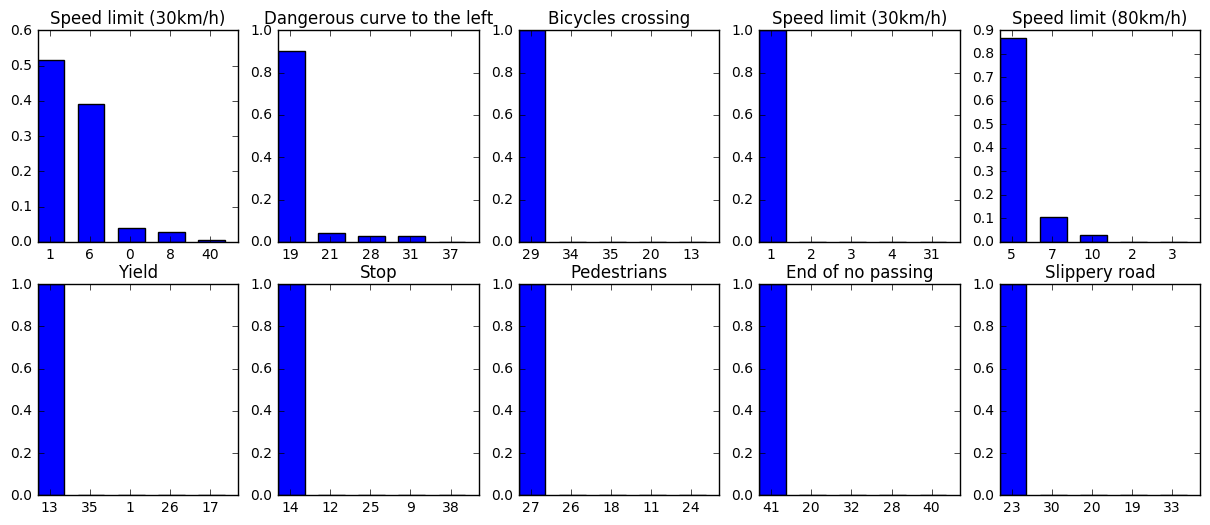

In [110]:
plt.figure(figsize=(15,6))
wid = 1/1.5
for img in range(10):
    plt.subplot(2,5,img+1)
    plt.title(sign_name_dict[str(predictions[img])])
#     xx = [str(a) for a in top_k_predictions.indices[img]]
    xx = [1,2,3,4,5]
    yy = top_k_predictions.values[img]
    plt.bar(xx,yy,wid,color="blue")
    plt.xticks([1.3,2.3,3.3,4.3,5.3], top_k_predictions.indices[img])

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

Below is my assessment of the certainty of the predictions:

**Image 1**:
- Correctly predicted _Speed limit (30km/h)_
- It was not certain of this though, since _6,End of speed limit (80km/h)_ was a close second

**Image 2**:
- Incorrectly predicted _19,Dangerous curve to the left_
- It seemed quite confident of this prediction
- The correct answer _31,Wild animals crossing_ was in the top 5

**Image 3**:
- Incorrectly predicted _29,Bicycles crossing_
- It seemed quite confident of this prediction
- The correct answer should have been something like 'steep incline' but it seems this was not in the list of classes

**Image 4**:
- Correctly predicted _Speed limit (30km/h)_
- It seemed confident of this

**Image 5**:
- Incorrectly predicted _5,Speed limit (80km/h)_
- It was not completely confident of this prediction
- The correct answer _2,Speed limit (50km/h)_ was in the top 5

**Image 6**:
- Correctly predicted _13,Yield_
- It seemed confident of this

**Image 7**:
- Incorrectly predicted _14,Stop_
- It seemed quite confident of this prediction
- The correct answer _28,Children crossing_ was not in the top 5

**Image 8**:
- Incorrectly predicted _27,Pedestrians_
- It seemed quite confident of this prediction
- The correct answer _26,Traffic signals_ was in the top 5

**Image 9**:
- Incorrectly predicted _41,End of no passing_
- It seemed quite confident of this prediction
- The correct answer _20,Dangerous curve to the right_ was in the top 5

**Image 10**:
- Correctly predicted _23,Slippery road_
- It seemed confident of this



> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.